# Démonstration : ouverture d'une plaque image au format HDF5

On importe les librairies nécessaires : les habituels `numpy` et `matplotlib`, mais aussi :

* La librairie `fabio` permet de charger les images 2D issue des détecteurs de rayons X. 
* La librairie `pyFAI` permet l'intégration azimuthale des plaques images (FAI : Fast Azimuthal Integrator)
* La librairie `tifffile` qui permet le traitement d'images au formats tiff (le masque dessiné avec Dioptas ici).

__Attention__: En cas d'erreur(s) dans ce notebook, il peut être nécessaire d'installer manuellement les packages suivants: `h5py`, `hdf5plugin`, `pyopencl`, `libtiff`, et/ou `imagecodecs`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import fabio 
import pyFAI
import tifffile

# Chargement de la calibration, de la plaque image et du masque

In [2]:
# On charge dans ai le fichier de calibration .poni (généré par exemple avec Dioptas) :
ai = pyFAI.load('calib.poni')

# Plaque image (h5):
f = 'eiger_0000.h5'

# on ouvre la plaque image avec fabio
img = fabio.open(f)

# on charge le masque (celui-ci a été généré avec Dioptas) en utilisant la librairie tifffile :
mask = tifffile.imread('image.mask')

# Image brute

On peut afficher l'image brute avec la fonction `imshow` de `matplotlib.pyplot` :

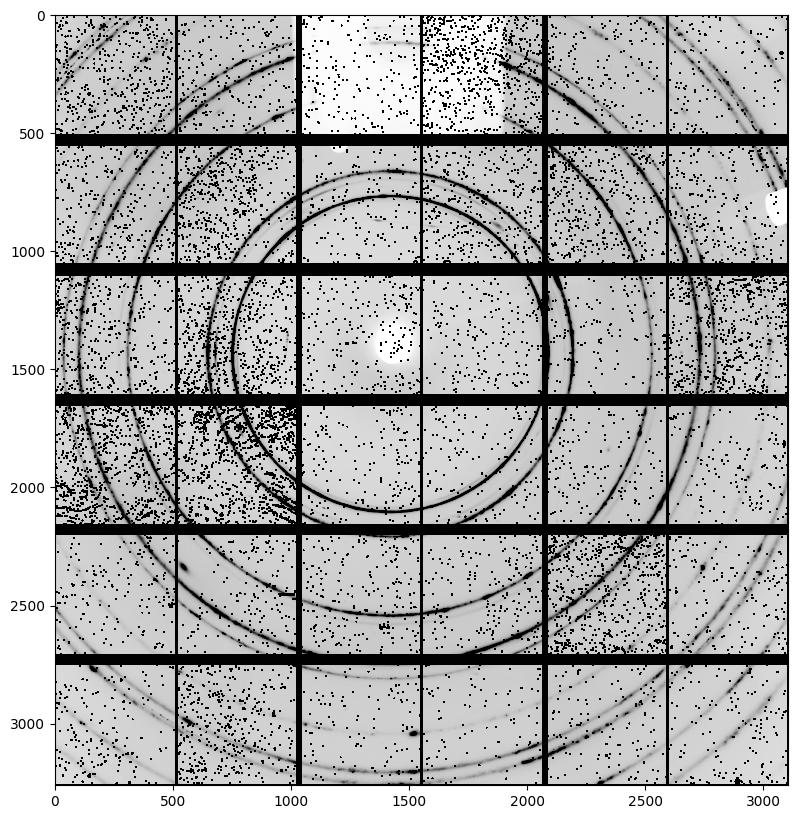

In [3]:
fig, ax = plt.subplots(figsize=(10,10))

# on trace img.data qui contient les données de la plaque image sous la forme d'un tableau 2D:

ax.imshow(img.data, 
          vmin=0,        # min
          vmax=2000,     # max
          cmap='binary') # colormap : noir et blanc

Il est judicieux de vérifier que le masque est correctement défini :

In [4]:
mask

array([[1, 1, 1, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=int32)

Nous voyons qu'il s'agit d'un tableau 2D de 0 et de 1 (non masqué et masqué, respectivement). Nous pouvons générer à nouveau la figure, tout en superposant le masque en transparence afin de vérifier son bon comportement :

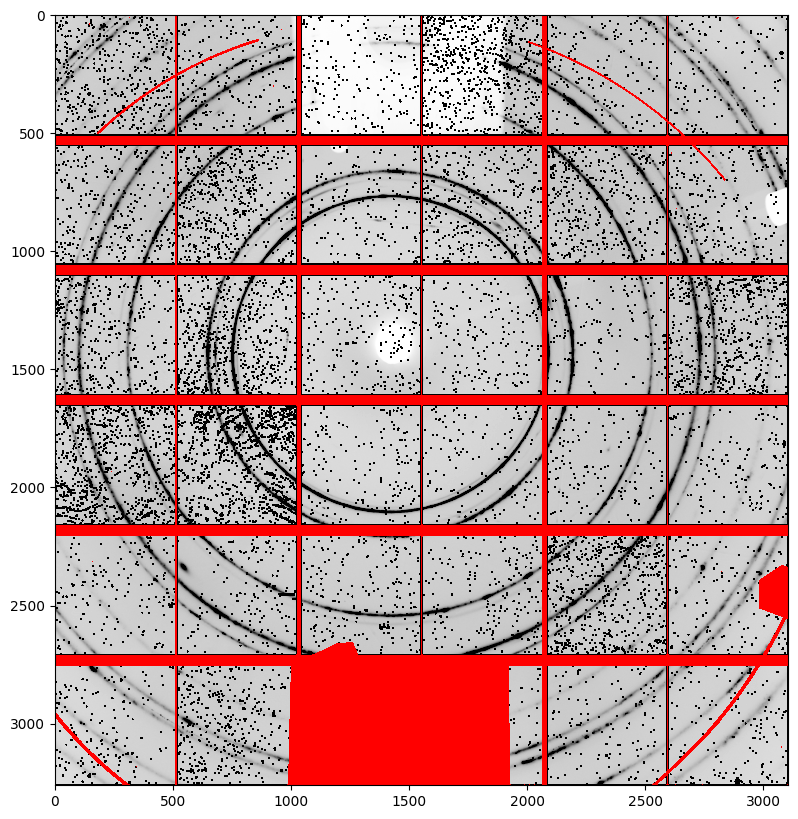

In [5]:
fig, ax = plt.subplots(figsize=(10,10))

ax.imshow(img.data, 
          vmin=0,        # min
          vmax=2000,     # max (échelle de valeurs pour l'affichage)
          cmap='binary') # colormap : noir et blanc

# Nous allons créer notre propre colormap qui va de 'aucune couleur', pour non masqué (0) à rouge (1, masqué):

from matplotlib.colors import ListedColormap 
mask_cmap = ListedColormap(['None', 'red'])

# on ajoute le masque sur le même graphique avec notre colormap :
ax.imshow(mask, 
          vmin=0, 
          vmax=1,
          cmap = mask_cmap)

Nous voyons que le masque est inversé de haut en bas par rapport à la plaque image (il s'agit en fait d'une inversion due à l'utilisation de Dioptas pour créer le masque, car Dioptas renverse l'image brute).  Il nous suffit d'inverser l'image brute (`img.data`) de haut en bas avec la fonction [`np.flipud`](https://numpy.org/doc/stable/reference/generated/numpy.flipud.html) de `numpy` :

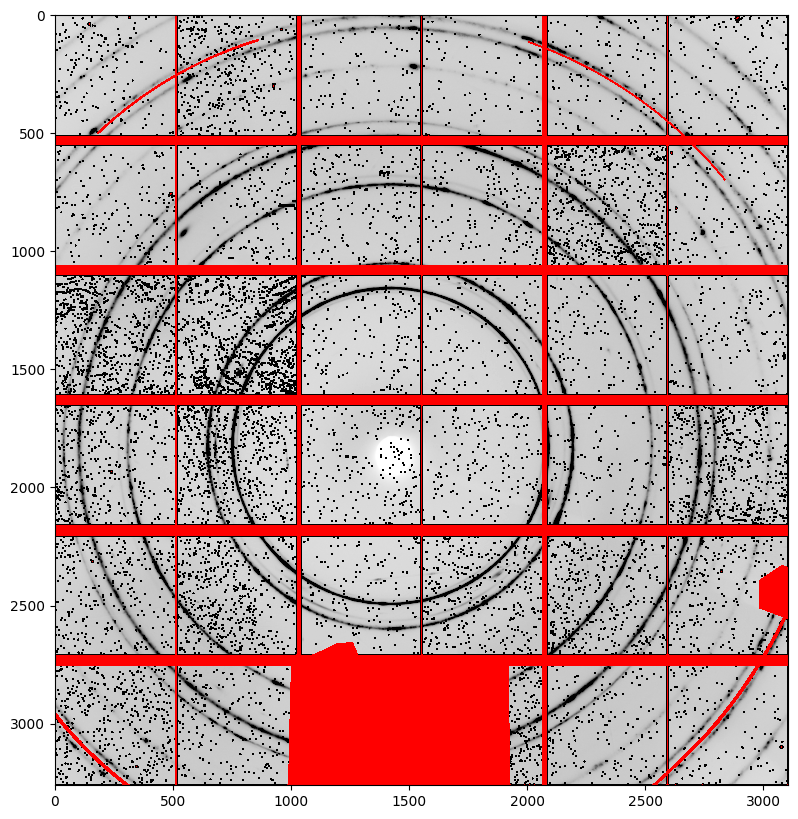

In [6]:
# on définit un nouveau tableau :
flipped_data = np.flipud(img.data)

# On trace cette fois ci le tableau flipped_data dans une nouvelle figure:
fig, ax = plt.subplots(figsize=(10,10))

ax.imshow(flipped_data, 
          vmin=0,        # min
          vmax=2000,     # max
          cmap='binary') # colormap : noir et blanc

from matplotlib.colors import ListedColormap 
mask_cmap = ListedColormap(['None', 'red'])

# on ajoute le masque sur le même graphique avec notre colormap :
ax.imshow(mask, 
          vmin=0, 
          vmax=1,
          cmap = mask_cmap)

Nous obtenons le résultat voulu : le masque correspond bien aux régions que l'on souhaite masquer. 

# Intégration azimuthale

Nous allons utiliser la fonction [`integrate1d`](https://pyfai.readthedocs.io/en/v2023.1/api/pyFAI.html#module-pyFAI.azimuthalIntegrator) de l'objet `ai` pour calculer le pattern de diffraction intégré :

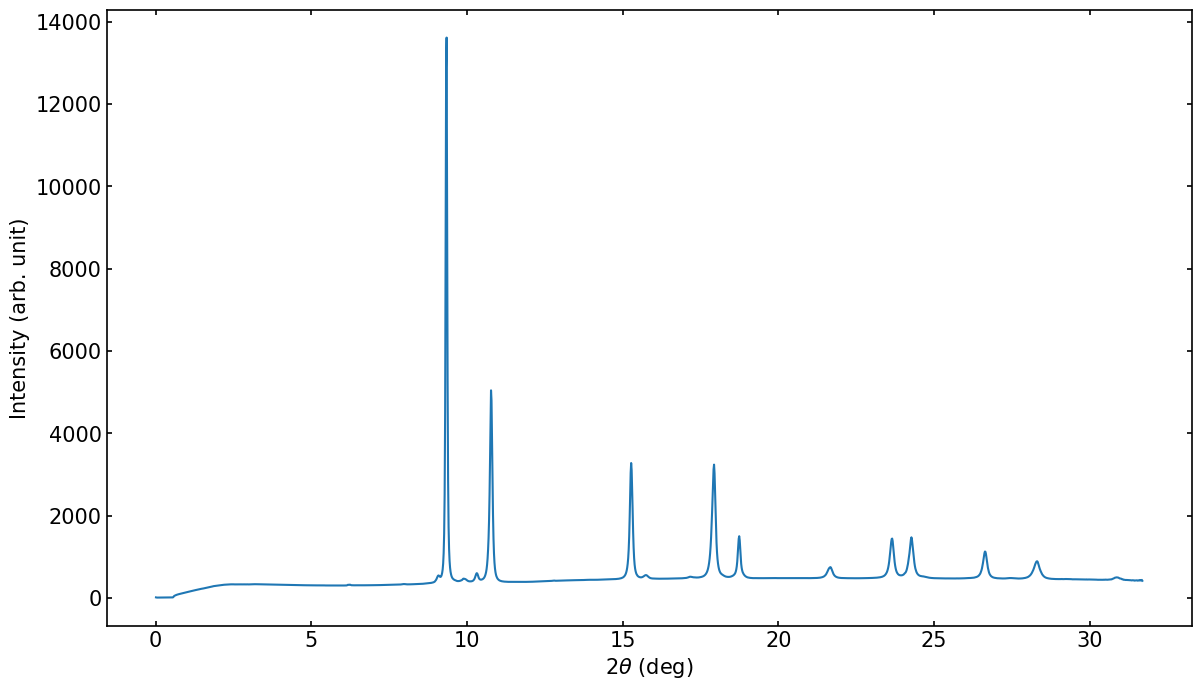

In [7]:
# Intégration : 2theta et intensité sont stockés dans tth1d et intens1d respectivement:
tth1d, intens1d = ai.integrate1d(flipped_data,   # image renversée
                                 2000,           # nombre de bin (binning) dans la direction radiale
                                 mask=mask,      # on reseigne le masque
                                 unit="2th_deg") # on souhaite travailler en unité 2theta (degrés)


# Traçons le pattern obtenu 

# Un petit exemple pour customiser les paramètres d'affichages de matplotlib (facultatif):
# Changer ces paramètres à un effet global sur l'ensemble du notebook
plt.rcParams.update({'font.size':15,       # taille de police
                     'axes.linewidth':1.2, # largeur des axes/bordures
                     'xtick.major.width':1.2, # largeur des 'ticks'
                     'ytick.major.width':1.2,
                     'xtick.direction': 'in', # direction des ticks (ici vers l'intérieur du graphe)
                     'ytick.direction': 'in',
                     'xtick.top': True,      # ticks aussi en haut
                     'ytick.right': True})   # ticks aussi à droite


# graphique : 
fig, ax = plt.subplots(figsize=(14,8))

ax.set_xlabel('2$\\theta$ (deg)')
ax.set_ylabel('Intensity (arb. unit)')

ax.plot(tth1d, intens1d)

Nous avons extrait le pattern de diffraction, qui peut ensuite être analysé plus en détails. 

# Image "cake"

Nous pouvons également afficher la plaque image dépliée sous la forme "cake" en utilisant la fonction [`integrate2d`](https://pyfai.readthedocs.io/en/v2023.1/api/pyFAI.html#module-pyFAI.azimuthalIntegrator) de l'objet `ai`.

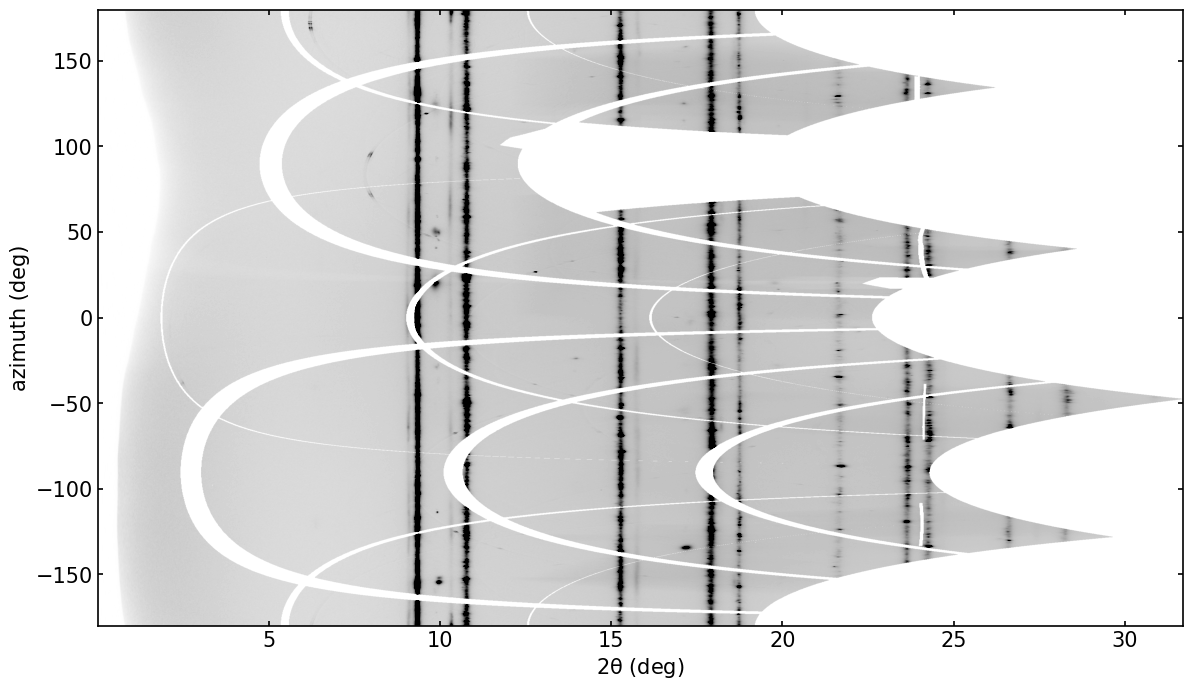

In [8]:
# Intégration : 2theta, intensité, et l'angle azimuthal chi sont stockés dans tth, intens, et chi respectivement.
intens, tth, chi = ai.integrate2d(flipped_data, # image renversée 
                                  2000,         # bins direction radiale
                                  2000,         # bins direction azimuthale
                                  mask=mask,    # masque
                                  unit="2th_deg") 

# On crée une nouvelle figure :
fig, ax = plt.subplots(figsize=(14,8))

ax.set_xlabel('2$\mathrm{\\theta}$ (deg)')
ax.set_ylabel('azimuth (deg)')

# on trace le cake :
ax.imshow(intens, 
          origin="lower",                                       
          extent=[tth.min(), tth.max(), chi.min(), chi.max()], 
          aspect="auto", 
          vmin=0, 
          vmax=2000,
          cmap='binary')

Nous avons ici utilisé les arguments *origin* et *extent* (qui fixent l'origine de l'image, et les bornes de l'image dans les coordonnées des données) de la fonction `imshow` pour un affichage correct des valeurs sur les axes. Pour plus de détails, voir [cette page](https://matplotlib.org/stable/users/explain/artists/imshow_extent.html#imshow-extent).